The first step is to upload both datasets:

In [1]:
import pandas as pd
df = pd.read_csv('takehome_users.csv')

In [2]:
import pandas as pd
df2 = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


# Data Wrangling

I have to convert the time_stamp column into a date time series:

In [7]:
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

I will extract the week portion of the time_stamp column to analyze 7-day intervals in regards to the users:

In [8]:
df2['week'] = df2['time_stamp'].dt.isocalendar().week
df2 = df2.groupby(['week','user_id'])['time_stamp'].count().reset_index(name="log_in_count")

adopted_user = df2[df2.log_in_count >= 3]

In [9]:
print(len(adopted_user['user_id'].unique()), "are adopted users out of", len(df2.user_id.unique()), "in total")
print(round(1445*100/8823,2),"% of users are adopted")

1445 are adopted users out of 8823 in total
16.38 % of users are adopted


In [10]:
adopted_user.head()

,week,user_id,log_in_count
1,1,10,5
2,1,42,4
5,1,63,7
6,1,69,10
7,1,81,3


I then added a new column, is_adopted_user, such that 1 represents an adopted user, i.e. one who logs in 3 or more times in a given 7-day period, and 0 other wise:

In [11]:
import numpy as np
df['is_adopted_user'] = np.where(df['object_id'].isin(adopted_user['user_id']),1,0)

In [12]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [15]:
df.is_adopted_user.sum()

1445

# EDA

In [16]:
df['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

Organization Invites are responsible for the largest proportion of adopted users
Personal Projects account for the smallest proportion of adopted users


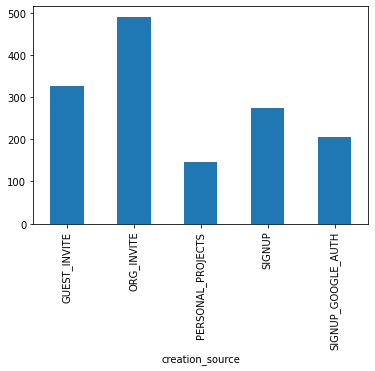

In [17]:
import matplotlib.pyplot as plt

#calculate sum of points for each team
df.groupby('creation_source')['is_adopted_user'].sum().plot(kind='bar')
print("Organization Invites are responsible for the largest proportion of adopted users")
print("Personal Projects account for the smallest proportion of adopted users")

Organization Invitations are responsible for the largest proportion of users in total
Registration via Google Authorization is responsible for the smallest proportion of users in total


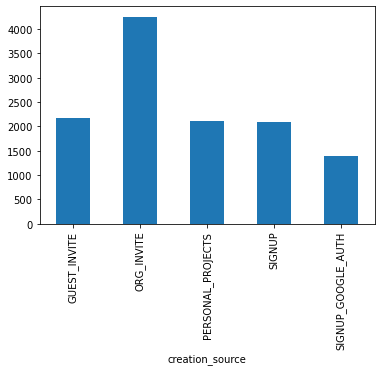

In [18]:
df.groupby('creation_source')['object_id'].count().plot(kind='bar')
print("Organization Invitations are responsible for the largest proportion of users in total")
print("Registration via Google Authorization is responsible for the smallest proportion of users in total")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  is_adopted_user             12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


I have null values in columns 5 and 9. I will fix those now.

In [20]:
df['invited_by_user_id'] = df['invited_by_user_id'].fillna(0)

In [21]:
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(0)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  12000 non-null  float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          12000 non-null  float64
 10  is_adopted_user             12000 non-null  int32  
dtypes: float64(2), int32(1), int64(4), object(4)
memory usage: 984.5+ KB


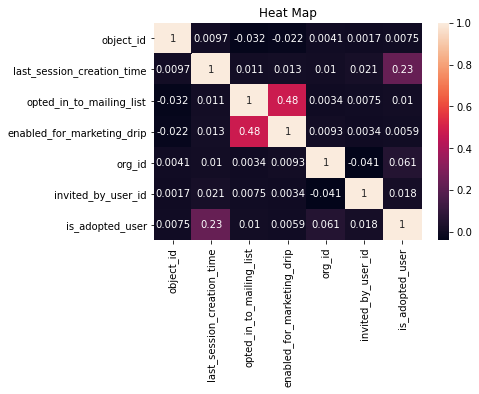

In [23]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True)
plt.title('Heat Map')
plt.show()

In [24]:
df_for_testing = df

In [25]:
df_for_testing.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [26]:
df_for_testing = pd.get_dummies(df_for_testing, columns=['creation_source'], drop_first=False, dtype=int)


In [27]:
df_for_testing.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0


In [28]:
df_for_testing.drop(['creation_time', 'name','email'], axis=1, inplace=True)


In [29]:
df_for_testing.head()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1.398139e+09,1,0,11,10803.0,0,1,0,0,0,0
1,2,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0
2,3,1.363735e+09,0,0,94,1525.0,0,0,1,0,0,0
3,4,1.369210e+09,0,0,1,5151.0,0,1,0,0,0,0
4,5,1.358850e+09,0,0,193,5240.0,0,1,0,0,0,0


# Test/Training Sets

In [30]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
 
 
# Initialise the Scaler
scaler = StandardScaler()
 
# To scale data
scaler.fit(df_for_testing)

StandardScaler()

In [31]:
>>> import pandas as pd
>>> from sklearn.model_selection import train_test_split
>>> from sklearn.datasets import load_iris

y = df_for_testing.is_adopted_user
x = df_for_testing.drop('is_adopted_user', axis = 1)

In [32]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
x_train.head()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
2395,2396,1.401368e+09,1,0,57,5408.0,0,1,0,0,0
9384,9385,1.376474e+09,0,0,37,0.0,0,0,0,1,0
2954,2955,1.372441e+09,1,0,247,5644.0,0,1,0,0,0
4163,4164,1.401165e+09,0,0,3,11911.0,0,1,0,0,0
3858,3859,1.397406e+09,0,0,193,0.0,0,0,1,0,0


In [33]:
y_train.head()


2395    0
9384    0
2954    0
4163    0
3858    0
Name: is_adopted_user, dtype: int32

In [54]:
from sklearn.metrics import classification_report, accuracy_score
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('The accuracy score of this test set was', round((accuracy_score(y_test, y_pred)*100),2),"%")
print(classification_report(y_test, y_pred))

The accuracy score of this test set was 92.17 %
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2108
           1       0.72      0.59      0.65       292

    accuracy                           0.92      2400
   macro avg       0.83      0.78      0.80      2400
weighted avg       0.92      0.92      0.92      2400



In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
LR_model = LogisticRegression().fit(x_train,y_train)
print("The logistic regression model was",round((LR_model.score(x_test,y_test)*100),2),"% correct")

The logistic regression model was 87.83 % correct


In [53]:
from sklearn.ensemble import RandomForestClassifier
RFC_model = RandomForestClassifier(random_state = 42).fit(x_train,y_train)
print("The Random Forest Classifier was", round((RFC_model.score(x_test,y_test)*100),2),"%")

The Random Forest Classifier was 92.08 %


In [41]:
importances = model.feature_importances_
importance_features = pd.Series(model.feature_importances_, index=x.columns)
print(importance_features*100)

object_id                             11.296668
last_session_creation_time            67.325248
opted_in_to_mailing_list               0.869989
enabled_for_marketing_drip             0.714357
org_id                                11.408579
invited_by_user_id                     6.076493
creation_source_GUEST_INVITE           0.405729
creation_source_ORG_INVITE             0.451277
creation_source_PERSONAL_PROJECTS      0.803649
creation_source_SIGNUP                 0.313078
creation_source_SIGNUP_GOOGLE_AUTH     0.334932
dtype: float64


# Findings/Recommendations
I implemented a series of models predicting up to 92% correctly whether or not a customer is and adopted one. After using importance features, I then found that the most recent sessions, the organization id and the person who invited them are the largest determiners of longterm user retention. 